# Getting started with graph convolutions

**Author**: Dennis Ramondt

**Conference**: PyData Eindhoven 2020

**Talk**: Monitoring a TV streaming service with AI - from PageRank to graph convolutions

This notebook gives an primer to using graph convolutions, simple node embeddings and supervised pagerank. We use the well known public `Cora` dataset.

All you'll need is `tensorflow 2.1.0`, as it's listed in the requirements.txt.

In [4]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import sys

## 0. Data preparation

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [5]:
from gcn.utils import *

In [6]:
DATASET = 'cora'
X, A, y = load_data(path='gcn/data/cora/', dataset=DATASET)

Loading cora dataset...
Dataset has 2708 nodes, 5429 edges, 1433 features.


In [458]:
y.shape

(2708, 7)

In [7]:
num_nodes = A.shape[1]
num_features = X.shape[1]
num_categories = y.shape[1]

We use a simple utility function to create training masks. These can be used during training to effectively hold out some part of the training data for validation afterwards.

In [8]:
y_train, y_val, y_test, idx_train, idx_val, idx_test, train_mask = get_splits(y)

In order to do proper graph deep learning, it's important to normalize the feature and adjacency matrices.

In [9]:
X /= X.sum(1).reshape(-1, 1)

In [10]:
A_ = preprocess_adj(A, symmetric=True)

## 1. Basic Graph Convolution

The basic graph convolution, as outlined in the talk, works by propagating node feature information using the adjacency matrix. This implementation is inspired by Thomas Kipf's seminal paper: https://arxiv.org/pdf/1609.02907.pdf

In [11]:
from tensorflow.keras.layers import Dense, Input, Add, Dropout
from gcn.layers.graph import PersonalizedPageRank, GraphConvolution
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

In order to get the graph convolutions working, we need to pass both the feature matrix and the adjacency matrix as Layer inputs:

In [59]:
G = Input(shape=(num_nodes, num_nodes))
X_in = Input(shape=(num_nodes, num_features,))
graph = [np.expand_dims(X, 0), np.expand_dims(A_.todense(), 0)]

Convolutional layers can be stacked at will, depending on how far you want the messages to be passed through the graph.

In [60]:
H = Dropout(0.5)(X_in)
H = GraphConvolution(32, activation='relu')([H,G])
H = Dropout(0.5)(H)
H = GraphConvolution(32, activation='relu')([H,G])
H = Dropout(0.5)(H)
H = GraphConvolution(32, activation='relu')([H,G])
Y = Dense(num_categories, activation='softmax')(H)

model = Model(inputs=[X_in,G], outputs=Y)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), sample_weight_mode='temporal')

In [12]:
model.fit(graph, np.expand_dims(y_train, 0), sample_weight=np.expand_dims(train_mask, 0),
          batch_size=num_nodes, epochs=50, shuffle=False, verbose=2)

  ...
    to  
  ['...']
Train on 1 samples
Epoch 1/50
1/1 - 1s - loss: 0.1006
Epoch 2/50
1/1 - 0s - loss: 0.0998
Epoch 3/50
1/1 - 0s - loss: 0.0988
Epoch 4/50
1/1 - 0s - loss: 0.0976
Epoch 5/50
1/1 - 0s - loss: 0.0959
Epoch 6/50
1/1 - 0s - loss: 0.0950
Epoch 7/50
1/1 - 0s - loss: 0.0936
Epoch 8/50
1/1 - 0s - loss: 0.0935
Epoch 9/50
1/1 - 0s - loss: 0.0934
Epoch 10/50
1/1 - 0s - loss: 0.0935
Epoch 11/50
1/1 - 0s - loss: 0.0922
Epoch 12/50
1/1 - 0s - loss: 0.0909
Epoch 13/50
1/1 - 0s - loss: 0.0904
Epoch 14/50
1/1 - 0s - loss: 0.0895
Epoch 15/50
1/1 - 0s - loss: 0.0884
Epoch 16/50
1/1 - 0s - loss: 0.0875
Epoch 17/50
1/1 - 0s - loss: 0.0871
Epoch 18/50
1/1 - 0s - loss: 0.0858
Epoch 19/50
1/1 - 0s - loss: 0.0829
Epoch 20/50
1/1 - 0s - loss: 0.0812
Epoch 21/50
1/1 - 0s - loss: 0.0786
Epoch 22/50
1/1 - 0s - loss: 0.0762
Epoch 23/50
1/1 - 0s - loss: 0.0747
Epoch 24/50
1/1 - 0s - loss: 0.0726
Epoch 25/50
1/1 - 0s - loss: 0.0706
Epoch 26/50
1/1 - 0s - loss: 0.0678
Epoch 27/50
1/1 - 0s - loss: 

In [13]:
preds = model.predict(graph, batch_size=A.shape[0])

For evaluating the predictions, we use the indices for the training mask to split into validation and training sets to see the accuracy and categorical cross entropy loss.

In [14]:
train_val_loss, train_val_acc = evaluate_preds(preds[0], [y_train, y_val],
                                               [idx_train, idx_val])

In [15]:
train_val_acc

[0.9285714285714286, 0.75]

As we can see, the validation accuracy is around 75%. Optimal benchmarks for `Cora` are somewhere in the 80s.

## 2. Personalized PageRank

An alternative approach is to use the pagerank algorithm to propagate information through the graph. It also uses the adjacency matrix, but can pass messages deeper in the graph due to the multiple (here 10) power iterations.

Note that it doesn't use a kernel to weight the message passing so will not learn which adjacency weights to prefer during propagation. This means the algorithm is not suitable when the adjacency matrix is very sparse and the node features themselves contain little signal.

Furthermore, a nice feature is that it is used as a final layer, hence you can use normal dense layers to learn information from the features themselves before propagating the learned representation.

In [18]:
H = Dense(64)(X_in)
H = Dense(64)(H)
H = Dense(num_categories, activation='softmax')(H)
Y = PersonalizedPageRank(alpha=0.1, niter=10, keep_prob=0.5)([H,G])

model = Model(inputs=[X_in,G], outputs=Y)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), sample_weight_mode='temporal')

In [19]:
model.fit(graph, np.expand_dims(y_train, 0), sample_weight=np.expand_dims(train_mask, 0),
          batch_size=num_nodes, epochs=50, shuffle=False, verbose=2)

  ...
    to  
  ['...']
Train on 1 samples
Epoch 1/50
1/1 - 2s - loss: 0.1007
Epoch 2/50
1/1 - 0s - loss: 0.0976
Epoch 3/50
1/1 - 0s - loss: 0.0941
Epoch 4/50
1/1 - 0s - loss: 0.0910
Epoch 5/50
1/1 - 0s - loss: 0.0895
Epoch 6/50
1/1 - 0s - loss: 0.0877
Epoch 7/50
1/1 - 0s - loss: 0.0848
Epoch 8/50
1/1 - 0s - loss: 0.0819
Epoch 9/50
1/1 - 0s - loss: 0.0774
Epoch 10/50
1/1 - 0s - loss: 0.0738
Epoch 11/50
1/1 - 0s - loss: 0.0690
Epoch 12/50
1/1 - 0s - loss: 0.0646
Epoch 13/50
1/1 - 0s - loss: 0.0592
Epoch 14/50
1/1 - 0s - loss: 0.0550
Epoch 15/50
1/1 - 0s - loss: 0.0515
Epoch 16/50
1/1 - 0s - loss: 0.0454
Epoch 17/50
1/1 - 0s - loss: 0.0418
Epoch 18/50
1/1 - 0s - loss: 0.0390
Epoch 19/50
1/1 - 0s - loss: 0.0367
Epoch 20/50
1/1 - 0s - loss: 0.0324
Epoch 21/50
1/1 - 0s - loss: 0.0314
Epoch 22/50
1/1 - 0s - loss: 0.0282
Epoch 23/50
1/1 - 0s - loss: 0.0262
Epoch 24/50
1/1 - 0s - loss: 0.0254
Epoch 25/50
1/1 - 0s - loss: 0.0234
Epoch 26/50
1/1 - 0s - loss: 0.0202
Epoch 27/50
1/1 - 0s - loss: 

In [20]:
preds = model.predict(graph, batch_size=A.shape[0])

In [21]:
train_val_loss, train_val_acc = evaluate_preds(preds[0], [y_train, y_val],
                                               [idx_train, idx_val])

In [22]:
train_val_acc

[0.9714285714285714, 0.83]

Interestingly, we get much higher accuracy here, suggesting that the node features already contain a lot of information and pagerank helps to send this deep enough into the graph.

## 3. Node feature embedding

In many real-world scenarios not every node in the graph will be similar. For example, different node types may have different feature sets. This heterogeneity means graph convolutions will not work out of the box. A simple approach to fix this is to first embed the different features into the same dimension and then add them together. After that, simple graph convolutions can be used.

Here, we have slices the node feature matrix into two distinct feature sets. We have then given one half of the nodes the first feature set, and the other half the second feature set. Let's see if they are still able to learn anything meaningful.

In [23]:
indices = np.random.choice([0,1], p=[0.5, 0.5], size=num_features)
Xs = [X[:,np.where(indices==0)[0]], X[:,np.where(indices==1)[0]]]
G = Input(shape=(num_nodes, num_nodes))
Xs_in = [Input(shape=(X.shape[0], X.shape[1])) for X in Xs]

graphs = [np.expand_dims(X, 0) for X in Xs] + [np.expand_dims(A_.todense(), 0)]

In [24]:
Xs_embed = [Dense(24, use_bias=False)(X) for X in Xs_in]
H = Add()(Xs_embed)
H = Dropout(0.5)(H)
H = GraphConvolution(32, activation='relu')([H,G])
H = Dropout(0.5)(H)
H = GraphConvolution(32, activation='relu')([H,G])
H = Dropout(0.5)(H)
H = GraphConvolution(32, activation='relu')([H,G])
Y = Dense(num_categories, activation='softmax')(H)

model = Model(inputs=[Xs_in,G], outputs=Y)
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), sample_weight_mode='temporal')

In [25]:
model.fit(graphs, np.expand_dims(y_train, 0), sample_weight=np.expand_dims(train_mask, 0),
          batch_size=num_nodes, epochs=50, shuffle=False, verbose=2)

  ...
    to  
  ['...']
Train on 1 samples
Epoch 1/50
1/1 - 1s - loss: 0.1006
Epoch 2/50
1/1 - 0s - loss: 0.0995
Epoch 3/50
1/1 - 0s - loss: 0.0981
Epoch 4/50
1/1 - 0s - loss: 0.0966
Epoch 5/50
1/1 - 0s - loss: 0.0947
Epoch 6/50
1/1 - 0s - loss: 0.0934
Epoch 7/50
1/1 - 0s - loss: 0.0934
Epoch 8/50
1/1 - 0s - loss: 0.0932
Epoch 9/50
1/1 - 0s - loss: 0.0923
Epoch 10/50
1/1 - 0s - loss: 0.0908
Epoch 11/50
1/1 - 0s - loss: 0.0882
Epoch 12/50
1/1 - 0s - loss: 0.0870
Epoch 13/50
1/1 - 0s - loss: 0.0852
Epoch 14/50
1/1 - 0s - loss: 0.0835
Epoch 15/50
1/1 - 0s - loss: 0.0813
Epoch 16/50
1/1 - 0s - loss: 0.0787
Epoch 17/50
1/1 - 0s - loss: 0.0760
Epoch 18/50
1/1 - 0s - loss: 0.0748
Epoch 19/50
1/1 - 0s - loss: 0.0731
Epoch 20/50
1/1 - 0s - loss: 0.0717
Epoch 21/50
1/1 - 0s - loss: 0.0691
Epoch 22/50
1/1 - 0s - loss: 0.0690
Epoch 23/50
1/1 - 0s - loss: 0.0678
Epoch 24/50
1/1 - 0s - loss: 0.0667
Epoch 25/50
1/1 - 0s - loss: 0.0628
Epoch 26/50
1/1 - 0s - loss: 0.0624
Epoch 27/50
1/1 - 0s - loss: 

In [26]:
preds = model.predict(graphs, batch_size=num_nodes)

In [27]:
train_val_loss, train_val_acc = evaluate_preds(preds[0], [y_train, y_val],
                                               [idx_train, idx_val])

In [28]:
train_val_acc

[0.9428571428571428, 0.7033333333333334]

The result is a bit lower than using graph convolutions on the full set of features for all nodes, but that is to be expected given that we have essentially removed half of the meaningful information when simulating the split into two disjoint node types.

## 4. Recurrent GCNs

Graph Convolutions can also be used in combination with time series. The PEMS-08 traffic dataset consists of 5-minute `flow`, `occupy` and `speed` measurements (aggregated from 30 second raw data) of 170 sensors along a network of highways in the major metropolitan areas in California. The objective is to predict sensor values at some future timestep `T`, making use of the road network structure. In this implementation we choose to predict one of the input features `T` timesteps ahead.

In [577]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.metrics import *

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Reshape, GRU, Lambda, TimeDistributed
from gcn.layers.graph import GraphConvolution
from gcn.utils import DataGenerator

We read the feature matrix, normalize it, and use the same adjacency matrix normalization as before.

In [521]:
# node features
X = np.load('gcn/data/pems/pems08.npz')['data']
X /= X.max(axis=0, keepdims=True)
X = np.expand_dims(X, 0)

# adjacency matrix
distance = pd.read_csv('gcn/data/pems/distance.csv').drop_duplicates()
A = sp.coo_matrix((distance['cost'], (distance['from'], distance['to'])), shape=(X.shape[2], X.shape[2]))
A_ = np.expand_dims(preprocess_adj(A, symmetric=False).todense(), 0).astype('float32')

We define a sequence length of 1 day:

In [532]:
seq_len = 288
n_nodes = A.shape[1]
n_features = X.shape[3]
train_frac = 0.9
train_idx = int(X.shape[1] * train_frac)

In [534]:
X_in = Input(shape=(seq_len, n_nodes, n_features,))
G = Input(shape=(n_nodes, n_nodes))

This data generator class returns node feature tensors of length `seq_len` together with the adjacency matrix for training and testing.

In [558]:
train_gen = DataGenerator(A_, X[:,:train_idx], target_distance=1, seq_length=seq_len, batch_size=64)
test_gen = DataGenerator(A_, X[:,train_idx:], target_distance=1, seq_length=seq_len, batch_size=64)

### 4.1 Approach 1: flattening sequences

The first and most naieve approach is to flatten the node feature sequences in the first layer into a single feature vector. That way they can be directly be passed through convolutional layers. Although the approach trains fast, there are some methodological concerns as temporal information is essentially jumbled when learning the convolutional weights.

In [559]:
H = Reshape((n_nodes, seq_len * n_features))(X_in)
H = GraphConvolution(32 * n_features, activation='relu')([H, G])
H = Dropout(0.2)(H)
H = GraphConvolution(16 * n_features, activation='relu')([H, G])
H = Dropout(0.2)(H)
H = Reshape((-1, n_nodes * n_features))(H)
H = GRU(32, return_sequences=True)(H)
H = Dropout(0.2)(H)
H = GRU(64)(H)
H = Dropout(0.2)(H)
Y = Dense(n_nodes, activation='sigmoid')(H)

In [560]:
model = Model(inputs=[X_in, G], outputs=Y)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [561]:
model.fit_generator(train_gen, epochs=1)

  ...
    to  
  ['...']
Train for 240 steps
240/240 [==============================] - 35s 145ms/step - loss: 0.1283 - mse: 0.0280


Validating the quality of predictions

In [566]:
outputs = [t[1] for t in test_gen]
y_true = np.concatenate(outputs, axis=0)
y_pred = model.predict(test_gen)

In [579]:
print(f'Mean Squared Error {mean_squared_error(y_true, y_pred)}')
print(f'Mean Absolute Error {mean_absolute_error(y_true, y_pred)}')

Mean Squared Error 0.01170817946986194
Mean Absolute Error 0.07594294214534236


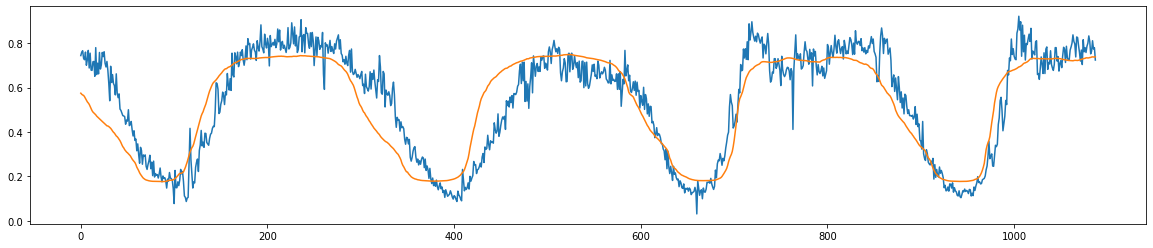

In [563]:
plt.figure(figsize=(20,4))
plt.plot(true[:,1])
plt.plot(predictions[:,1])

### 4.2 Approach 2: convolutions at each timestep
A more robust approach is to apply a graph convolution at each timestep, before passing the output to a conventional recurrent layer. This approach is inspired by a recent paper from Zhao et al. (2018). They actually build a convolutional layer into the GRU Cell entry gate itself, but the current Keras implementation for recurrent cells is so entangled that it is a chore to replicate and insert the convolutions.

Instead, one can apply the graph convolutions in time distributed fashion with Keras, and then pass the result into a conventional recurrent layer. Unfortunately (as is the case with the paper's implementation as well), a full convolution that includes the weight kernel is extremely slow. I therefore chose to only implement the propagation step to reduce the amount of weights that need to be trained.

**Reference**
Zhao et al. (T-GCN: A Temporal Graph Convolutional Network for Traffic Prediction (IEEE Transactions on Intelligent Transportation Systems 2019))

https://arxiv.org/abs/1811.05320

In [580]:
H = TimeDistributed(Lambda(lambda x: K.batch_dot(A_, x)))(X_in)
H = TimeDistributed(Lambda(lambda x: K.batch_dot(A_, x)))(H)
H = Reshape((seq_len, n_nodes * n_features))(H)
H = GRU(32, return_sequences=True)(H)
H = Dropout(0.2)(H)
H = GRU(64)(H)
H = Dropout(0.2)(H)
Y = Dense(n_nodes, activation='sigmoid')(H)

In [581]:
model = Model(inputs=[X_in, G], outputs=Y)
model.compile(optimizer="adam", loss="mae", metrics=["mse"])

In [582]:
model.fit_generator(train_gen, epochs=1)

  ...
    to  
  ['...']
Train for 240 steps
240/240 [==============================] - 145s 603ms/step - loss: 0.1067 - mse: 0.0207


Validating the quality of predictions

In [583]:
outputs = [t[1] for t in test_gen]
y_true = np.concatenate(outputs, axis=0)
y_pred = model.predict(test_gen)

In [584]:
print(f'Mean Squared Error {mean_squared_error(y_true, y_pred)}')
print(f'Mean Absolute Error {mean_absolute_error(y_true, y_pred)}')

Mean Squared Error 0.010960577736111539
Mean Absolute Error 0.07530168974569727


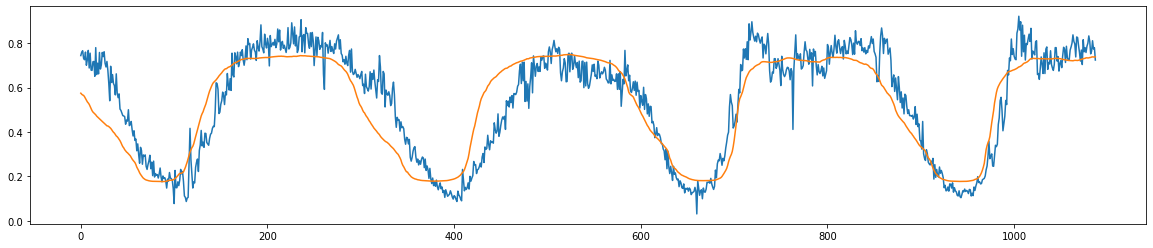

In [585]:
plt.figure(figsize=(20,4))
plt.plot(true[:,1])
plt.plot(predictions[:,1])